In [1]:
from collections import defaultdict, Counter
from itertools import combinations
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import math

#PREPROCESSING
# There are several skills that are represented by different terms, therefore I created skill_mapping which can be manually enlarged
SKILL_MAPPING = {
    "problem solving": "problem solving",
    "problemsolving": "problem solving",
    "communication skills": "communication",
    "communication": "communication",
}

# Normalization is needed, approached through mapping
def normalize_skills(transactions):
    normalized_transactions = []
    for transaction in transactions:
        normalized_transaction = [
            SKILL_MAPPING.get(skill.lower().strip(), skill.lower().strip())
            for skill in transaction
        ]
        normalized_transactions.append(normalized_transaction)
    return normalized_transactions



In [2]:
# Hash function for bucket assignment
def hash_itemset(itemset, bucket_size):
    return hash(frozenset(itemset)) % bucket_size

# Calculation for support for itemsets with batching
def calculate_support_batched(itemsets, transactions_sparse, item_to_idx, min_support_count, batch_size=500):
    support_counts = defaultdict(int)
    num_batches = math.ceil(len(itemsets) / batch_size)

    for batch_idx in range(num_batches):
        batch_itemsets = itemsets[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        batch_indices = [[item_to_idx[item] for item in itemset] for itemset in batch_itemsets]

        for itemset, indices in zip(batch_itemsets, batch_indices):
            match_count = (transactions_sparse[:, indices].sum(axis=1) == len(itemset)).sum()
            if match_count >= min_support_count:
                support_counts[frozenset(itemset)] = match_count

    return support_counts


In [3]:
# PCY Algorithm
def get_frequent_itemsets_pcy(transactions, min_support, bucket_size):
    # Step 0: Convert transactions to sparse matrix
    unique_items = sorted(set(item for transaction in transactions for item in transaction))
    item_to_idx = {item: idx for idx, item in enumerate(unique_items)}
    transactions_idx = [[item_to_idx[item] for item in transaction] for transaction in transactions]

    row_indices, col_indices = [], []
    for i, transaction in enumerate(transactions_idx):
        row_indices.extend([i] * len(transaction))
        col_indices.extend(transaction)
    data = [1] * len(row_indices)
    transactions_sparse = csr_matrix((data, (row_indices, col_indices)), shape=(len(transactions), len(unique_items)))

    total_transactions = transactions_sparse.shape[0]
    min_support_count = math.ceil(min_support * total_transactions)

    # Count individual items
    item_counts = np.array(transactions_sparse.sum(axis=0)).flatten()
    frequent_1_itemsets = {frozenset([unique_items[i]]): count for i, count in enumerate(item_counts) if count >= min_support_count}

    # Building hash buckets for pairs
    buckets = Counter()
    for transaction in transactions:
        for pair in combinations(transaction, 2):
            bucket = hash_itemset(pair, bucket_size)
            buckets[bucket] += 1

    # Bitmap for buckets meeting minimum support
    bitmap = {bucket: count >= min_support_count for bucket, count in buckets.items()}

    # Frequent itemsets iterative generation
    frequent_itemsets = frequent_1_itemsets.copy()
    current_itemsets = list(frequent_1_itemsets.keys())
    k = 2

    while current_itemsets:
        # Generate candidate itemsets of size k lazily
        candidate_itemsets = (
            set(a).union(set(b))
            for a, b in combinations(current_itemsets, 2)
            if len(set(a).union(set(b))) == k
        )
        candidate_itemsets = [
            itemset for itemset in set(map(frozenset, candidate_itemsets))
            if bitmap.get(hash_itemset(itemset, bucket_size), False)
        ]

        # Calculate support for candidates in batches
        support_counts = calculate_support_batched(
            candidate_itemsets, transactions_sparse, item_to_idx, min_support_count
        )

        if not support_counts:
            break

        frequent_itemsets.update(support_counts)
        current_itemsets = list(support_counts.keys())
        k += 1

    return frequent_itemsets



In [4]:
# Generate association rules
def generate_rules(frequent_itemsets, min_confidence):
    rules = []
    for itemset, support in frequent_itemsets.items():
        if len(itemset) > 1:
            for consequence in itemset:
                antecedent = itemset - frozenset([consequence])
                if antecedent in frequent_itemsets:
                    antecedent_support = frequent_itemsets[antecedent]
                    confidence = support / antecedent_support
                    if confidence >= min_confidence:
                        rules.append((antecedent, frozenset([consequence]), confidence))
    return rules



In [5]:
# Load dataset and preprocess
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024
!unzip 1-3m-linkedin-jobs-and-skills-2024.zip

df = pd.read_csv('job_skills.csv')
df['job_skills'] = df['job_skills'].fillna('').astype(str)
df['job_skills'] = df['job_skills'].apply(lambda x: x.split(','))

transactions = normalize_skills(df['job_skills'].tolist())

# Define thresholds
min_support = 0.05
min_confidence = 0.2
bucket_size = 1000  # Increased size to reduce collisions

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
1-3m-linkedin-jobs-and-skills-2024.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  1-3m-linkedin-jobs-and-skills-2024.zip
replace job_skills.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
# Run PCY algorithm
frequent_itemsets = get_frequent_itemsets_pcy(transactions, min_support, bucket_size)

# Generate and display rules
rules = generate_rules(frequent_itemsets, min_confidence)

print("Frequent Itemsets:")
for itemset, support in frequent_itemsets.items():
    print(f"Itemset: {set(itemset)}, support: {support}")

print("\nAssociation Rules:")
for antecedent, consequence, confidence in rules:
    print(f"Rule: {set(antecedent)} -> {set(consequence)}, confidence: {confidence:.2f}")

Frequent Itemsets:
Itemset: {'attention to detail'}, support: 133975
Itemset: {'collaboration'}, support: 87116
Itemset: {'communication'}, support: 566092
Itemset: {'customer service'}, support: 278102
Itemset: {'data analysis'}, support: 81964
Itemset: {'high school diploma'}, support: 67267
Itemset: {'interpersonal skills'}, support: 100267
Itemset: {'inventory management'}, support: 71911
Itemset: {'leadership'}, support: 185187
Itemset: {'microsoft office suite'}, support: 75531
Itemset: {'nursing'}, support: 88015
Itemset: {'organizational skills'}, support: 75274
Itemset: {'patient care'}, support: 99926
Itemset: {'problem solving'}, support: 278361
Itemset: {'project management'}, support: 121563
Itemset: {'sales'}, support: 93031
Itemset: {'teamwork'}, support: 227609
Itemset: {'time management'}, support: 142911
Itemset: {'training'}, support: 83656
Itemset: {'customer service', 'leadership'}, support: 67349
Itemset: {'communication', 'interpersonal skills'}, support: 74736
I

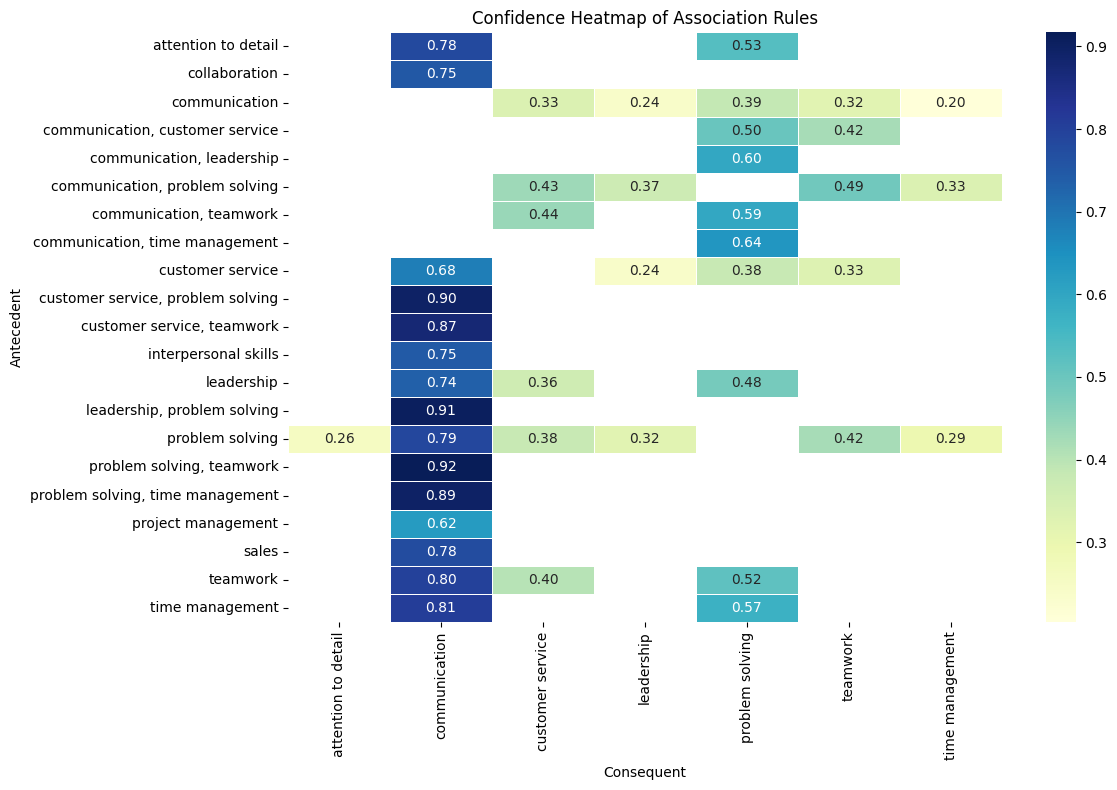

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_heatmap(rules):
    # Create a DataFrame for the heatmap
    antecedents = [', '.join(sorted(list(antecedent))) for antecedent, _, _ in rules]
    consequents = [', '.join(sorted(list(consequence))) for _, consequence, _ in rules]
    confidences = [confidence for _, _, confidence in rules]

    data = pd.DataFrame({
        'Antecedent': antecedents,
        'Consequent': consequents,
        'Confidence': confidences
    })

    # data for the heatmap (rows: antecedents, columns: consequents, values: confidence)
    heatmap_data = data.pivot(index='Antecedent', columns='Consequent', values='Confidence')

    # heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
    plt.title('Confidence Heatmap of Association Rules')
    plt.tight_layout()
    plt.show()

plot_heatmap(rules)


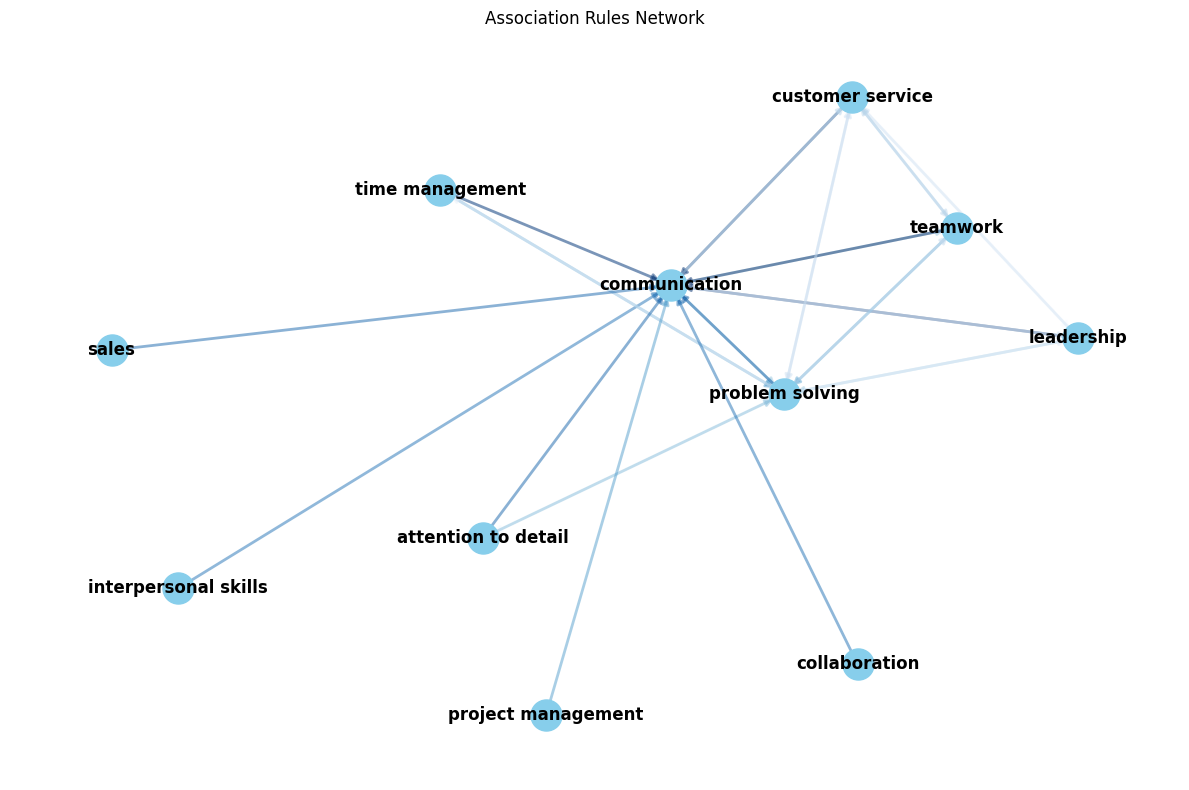

In [8]:
import networkx as nx

def plot_association_rules(rules):
    G = nx.DiGraph()

    for antecedent, consequence, confidence in rules:
        for item in antecedent.union(consequence):
            G.add_node(item)

        # Add edge with confidence as weight
        G.add_edge(tuple(antecedent)[0], tuple(consequence)[0], weight=confidence)

    # Draw the graph
    pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
    plt.figure(figsize=(12, 8))

    # Draw nodes and edges
    edges = G.edges()
    edge_weights = [G[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, alpha=0.5, edge_color=edge_weights, edge_cmap=plt.cm.Blues)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    plt.title('Association Rules Network')
    plt.axis('off')  # Turn off the axis
    plt.tight_layout()
    plt.show()

plot_association_rules(rules)
